In [8]:
from PIL import Image

In [ ]:
!zip -r animal_data.zip ./animal_data

In [9]:

import os
import pandas as pd

root_dir = "./animal_data/train"
cat_dir = os.path.join(root_dir, "cat")
dog_dir = os.path.join(root_dir, "dog")
wild_dir = os.path.join(root_dir, "wild")



cat = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.endswith((".png", ".jpg"))]
dog = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.endswith((".png", ".jpg"))]
wild = [os.path.join(wild_dir, f) for f in os.listdir(wild_dir) if f.endswith((".png", ".jpg"))]



df = pd.DataFrame({
    "image_path": cat + dog + wild ,
    "label": [0]*len(cat) + [1]*len(dog)  + [2] * len(wild) 
})



df.to_csv("animal_labels.csv", index=False)
print(f" 총 {len(df)}개 영상 라벨링 완료")
print(df.head())


 총 14630개 영상 라벨링 완료
                                      image_path  label
0  ./animal_data/train\cat\flickr_cat_000002.jpg      0
1  ./animal_data/train\cat\flickr_cat_000003.jpg      0
2  ./animal_data/train\cat\flickr_cat_000004.jpg      0
3  ./animal_data/train\cat\flickr_cat_000005.jpg      0
4  ./animal_data/train\cat\flickr_cat_000006.jpg      0


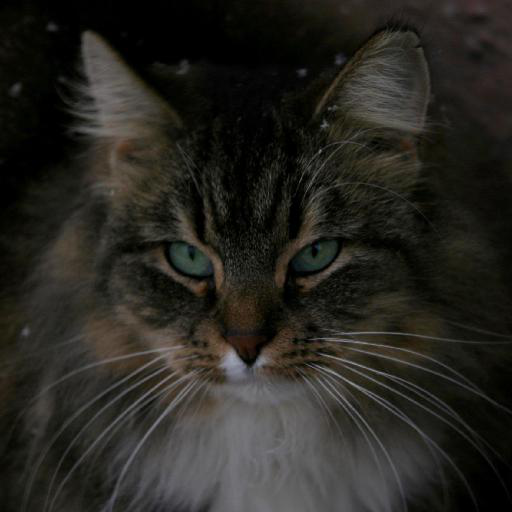

In [10]:
Image.open(df['image_path'].iloc[0]).convert("RGB")

In [13]:
from torch.utils.data import Dataset 

class AnimalDataset(Dataset):
    
    def __init__(self, csv_path, transform= None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform 
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        image_path = row["image_path"]
        label = int(row["label"])
        
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return {
            "pixel_values": image,
            "label": label
        }
        

In [22]:
from torchvision import transforms 
from torch.utils.data import DataLoader  as DL
import pandas as pd 


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

dataset = AnimalDataset("animal_labels.csv", transform)
loader = DL(dataset, batch_size=64, shuffle=True)



In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

In [23]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torchvision import models 
from PIL import Image  
from tqdm import tqdm  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : ", device)

num_classes = len(dataset.df['label'].unique())

model = models.resnet18(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
 
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

num_ep = 1
for ep in range(num_ep):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(loader, desc=f"Epoch {ep+1}/{num_ep}"):
        images = batch["pixel_values"].to(device)
        labels = torch.tensor(batch["label"], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
    acc = correct/total
    print(f"EPOCH : {ep}/{num_ep} | Loss : {total_loss/ len(loader): .4f} | ACC: {acc:.4f} ")
    


torch.save(model.state_dict(), "animal_predict_model.pth")

print("저장 완료")

c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device :  cuda


Epoch 1/1:   0%|          | 0/229 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_28504\3919395673.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["label"], dtype=torch.long).to(device)


tensor(1.2272, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   1%|          | 2/229 [00:02<03:58,  1.05s/it]

tensor(0.9441, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   1%|▏         | 3/229 [00:02<02:46,  1.36it/s]

tensor(0.5809, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   2%|▏         | 4/229 [00:03<02:11,  1.71it/s]

tensor(0.4138, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   2%|▏         | 5/229 [00:03<01:53,  1.98it/s]

tensor(0.2682, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   3%|▎         | 6/229 [00:03<01:41,  2.19it/s]

tensor(0.2324, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   3%|▎         | 7/229 [00:04<01:34,  2.36it/s]

tensor(0.1188, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   3%|▎         | 8/229 [00:04<01:28,  2.49it/s]

tensor(0.1071, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   4%|▍         | 9/229 [00:04<01:25,  2.57it/s]

tensor(0.0769, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   4%|▍         | 10/229 [00:05<01:23,  2.62it/s]

tensor(0.0586, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   5%|▍         | 11/229 [00:05<01:21,  2.67it/s]

tensor(0.0958, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   5%|▌         | 12/229 [00:06<01:20,  2.68it/s]

tensor(0.0691, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   6%|▌         | 13/229 [00:06<01:19,  2.70it/s]

tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   6%|▌         | 14/229 [00:06<01:19,  2.71it/s]

tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   7%|▋         | 15/229 [00:07<01:17,  2.75it/s]

tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   7%|▋         | 16/229 [00:07<01:17,  2.75it/s]

tensor(0.0927, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   7%|▋         | 17/229 [00:07<01:16,  2.77it/s]

tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   8%|▊         | 18/229 [00:08<01:15,  2.78it/s]

tensor(0.0549, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   8%|▊         | 19/229 [00:08<01:15,  2.79it/s]

tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   9%|▊         | 20/229 [00:08<01:15,  2.78it/s]

tensor(0.0770, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:   9%|▉         | 21/229 [00:09<01:14,  2.81it/s]

tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  10%|▉         | 22/229 [00:09<01:14,  2.79it/s]

tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  10%|█         | 23/229 [00:09<01:13,  2.80it/s]

tensor(0.0131, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  10%|█         | 24/229 [00:10<01:13,  2.77it/s]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  11%|█         | 25/229 [00:10<01:13,  2.77it/s]

tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  11%|█▏        | 26/229 [00:11<01:12,  2.78it/s]

tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  12%|█▏        | 27/229 [00:11<01:12,  2.78it/s]

tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  12%|█▏        | 28/229 [00:11<01:12,  2.78it/s]

tensor(0.0535, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  13%|█▎        | 29/229 [00:12<01:12,  2.77it/s]

tensor(0.0616, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  13%|█▎        | 30/229 [00:12<01:11,  2.77it/s]

tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  14%|█▎        | 31/229 [00:12<01:11,  2.76it/s]

tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  14%|█▍        | 32/229 [00:13<01:11,  2.77it/s]

tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  14%|█▍        | 33/229 [00:13<01:10,  2.76it/s]

tensor(0.0236, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  15%|█▍        | 34/229 [00:13<01:10,  2.78it/s]

tensor(0.0187, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  15%|█▌        | 35/229 [00:14<01:09,  2.79it/s]

tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  16%|█▌        | 36/229 [00:14<01:09,  2.77it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  16%|█▌        | 37/229 [00:14<01:09,  2.78it/s]

tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  17%|█▋        | 38/229 [00:15<01:09,  2.76it/s]

tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  17%|█▋        | 39/229 [00:15<01:08,  2.78it/s]

tensor(0.0691, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  17%|█▋        | 40/229 [00:16<01:07,  2.78it/s]

tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  18%|█▊        | 41/229 [00:16<01:07,  2.80it/s]

tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  18%|█▊        | 42/229 [00:16<01:06,  2.80it/s]

tensor(0.0352, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  19%|█▉        | 43/229 [00:17<01:06,  2.80it/s]

tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  19%|█▉        | 44/229 [00:17<01:05,  2.81it/s]

tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  20%|█▉        | 45/229 [00:17<01:05,  2.82it/s]

tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  20%|██        | 46/229 [00:18<01:05,  2.80it/s]

tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  21%|██        | 47/229 [00:18<01:04,  2.81it/s]

tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  21%|██        | 48/229 [00:18<01:04,  2.81it/s]

tensor(0.0087, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  21%|██▏       | 49/229 [00:19<01:04,  2.80it/s]

tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  22%|██▏       | 50/229 [00:19<01:04,  2.79it/s]

tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  22%|██▏       | 51/229 [00:20<01:03,  2.78it/s]

tensor(0.0445, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  23%|██▎       | 52/229 [00:20<01:03,  2.78it/s]

tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  23%|██▎       | 53/229 [00:20<01:03,  2.78it/s]

tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  24%|██▎       | 54/229 [00:21<01:02,  2.80it/s]

tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  24%|██▍       | 55/229 [00:21<01:02,  2.79it/s]

tensor(0.0079, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  24%|██▍       | 56/229 [00:21<01:02,  2.78it/s]

tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  25%|██▍       | 57/229 [00:22<01:01,  2.79it/s]

tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  25%|██▌       | 58/229 [00:22<01:02,  2.73it/s]

tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  26%|██▌       | 59/229 [00:22<01:01,  2.75it/s]

tensor(0.0569, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  26%|██▌       | 60/229 [00:23<01:01,  2.76it/s]

tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  27%|██▋       | 61/229 [00:23<01:00,  2.76it/s]

tensor(0.0834, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  27%|██▋       | 62/229 [00:23<01:00,  2.77it/s]

tensor(0.0229, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  28%|██▊       | 63/229 [00:24<00:59,  2.78it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  28%|██▊       | 64/229 [00:24<00:59,  2.77it/s]

tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  28%|██▊       | 65/229 [00:25<00:59,  2.76it/s]

tensor(0.0174, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  29%|██▉       | 66/229 [00:25<00:58,  2.77it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  29%|██▉       | 67/229 [00:25<00:58,  2.78it/s]

tensor(0.0191, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  30%|██▉       | 68/229 [00:26<00:57,  2.80it/s]

tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  30%|███       | 69/229 [00:26<00:57,  2.79it/s]

tensor(0.0297, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  31%|███       | 70/229 [00:26<00:57,  2.78it/s]

tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  31%|███       | 71/229 [00:27<00:56,  2.80it/s]

tensor(0.0478, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  31%|███▏      | 72/229 [00:27<00:55,  2.81it/s]

tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  32%|███▏      | 73/229 [00:27<00:55,  2.83it/s]

tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  32%|███▏      | 74/229 [00:28<00:54,  2.84it/s]

tensor(0.0346, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  33%|███▎      | 75/229 [00:28<00:54,  2.83it/s]

tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  33%|███▎      | 76/229 [00:28<00:54,  2.80it/s]

tensor(0.0403, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  34%|███▎      | 77/229 [00:29<00:53,  2.82it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  34%|███▍      | 78/229 [00:29<00:53,  2.82it/s]

tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  34%|███▍      | 79/229 [00:30<00:53,  2.83it/s]

tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  35%|███▍      | 80/229 [00:30<00:52,  2.84it/s]

tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  35%|███▌      | 81/229 [00:30<00:52,  2.82it/s]

tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  36%|███▌      | 82/229 [00:31<00:52,  2.82it/s]

tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  36%|███▌      | 83/229 [00:31<00:51,  2.81it/s]

tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  37%|███▋      | 84/229 [00:31<00:51,  2.83it/s]

tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  37%|███▋      | 85/229 [00:32<00:51,  2.82it/s]

tensor(0.0581, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  38%|███▊      | 86/229 [00:32<00:51,  2.80it/s]

tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  38%|███▊      | 87/229 [00:32<00:50,  2.79it/s]

tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  38%|███▊      | 88/229 [00:33<00:50,  2.80it/s]

tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  39%|███▉      | 89/229 [00:33<00:50,  2.78it/s]

tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  39%|███▉      | 90/229 [00:33<00:49,  2.79it/s]

tensor(0.0119, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  40%|███▉      | 91/229 [00:34<00:49,  2.80it/s]

tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  40%|████      | 92/229 [00:34<00:49,  2.79it/s]

tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  41%|████      | 93/229 [00:35<00:48,  2.82it/s]

tensor(0.0613, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  41%|████      | 94/229 [00:35<00:48,  2.78it/s]

tensor(0.0525, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  41%|████▏     | 95/229 [00:35<00:48,  2.78it/s]

tensor(0.0304, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  42%|████▏     | 96/229 [00:36<00:47,  2.78it/s]

tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  42%|████▏     | 97/229 [00:36<00:47,  2.78it/s]

tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  43%|████▎     | 98/229 [00:36<00:46,  2.79it/s]

tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  43%|████▎     | 99/229 [00:37<00:46,  2.81it/s]

tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  44%|████▎     | 100/229 [00:37<00:46,  2.80it/s]

tensor(0.0226, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  44%|████▍     | 101/229 [00:37<00:45,  2.80it/s]

tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  45%|████▍     | 102/229 [00:38<00:45,  2.80it/s]

tensor(0.0273, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  45%|████▍     | 103/229 [00:38<00:45,  2.78it/s]

tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  45%|████▌     | 104/229 [00:38<00:44,  2.79it/s]

tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  46%|████▌     | 105/229 [00:39<00:44,  2.80it/s]

tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  46%|████▋     | 106/229 [00:39<00:43,  2.80it/s]

tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  47%|████▋     | 107/229 [00:40<00:43,  2.81it/s]

tensor(0.0252, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  47%|████▋     | 108/229 [00:40<00:43,  2.77it/s]

tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  48%|████▊     | 109/229 [00:40<00:43,  2.79it/s]

tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  48%|████▊     | 110/229 [00:41<00:42,  2.77it/s]

tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  48%|████▊     | 111/229 [00:41<00:42,  2.79it/s]

tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  49%|████▉     | 112/229 [00:41<00:41,  2.79it/s]

tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  49%|████▉     | 113/229 [00:42<00:41,  2.80it/s]

tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  50%|████▉     | 114/229 [00:42<00:41,  2.79it/s]

tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  50%|█████     | 115/229 [00:42<00:40,  2.80it/s]

tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  51%|█████     | 116/229 [00:43<00:40,  2.79it/s]

tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  51%|█████     | 117/229 [00:43<00:39,  2.80it/s]

tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  52%|█████▏    | 118/229 [00:43<00:39,  2.78it/s]

tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  52%|█████▏    | 119/229 [00:44<00:39,  2.80it/s]

tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  52%|█████▏    | 120/229 [00:44<00:39,  2.79it/s]

tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  53%|█████▎    | 121/229 [00:45<00:39,  2.77it/s]

tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  53%|█████▎    | 122/229 [00:45<00:38,  2.75it/s]

tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  54%|█████▎    | 123/229 [00:45<00:38,  2.76it/s]

tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  54%|█████▍    | 124/229 [00:46<00:37,  2.81it/s]

tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  55%|█████▍    | 125/229 [00:46<00:37,  2.79it/s]

tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  55%|█████▌    | 126/229 [00:46<00:36,  2.79it/s]

tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  55%|█████▌    | 127/229 [00:47<00:36,  2.79it/s]

tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  56%|█████▌    | 128/229 [00:47<00:36,  2.79it/s]

tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  56%|█████▋    | 129/229 [00:47<00:35,  2.79it/s]

tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  57%|█████▋    | 130/229 [00:48<00:35,  2.78it/s]

tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  57%|█████▋    | 131/229 [00:48<00:35,  2.79it/s]

tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  58%|█████▊    | 132/229 [00:49<00:34,  2.80it/s]

tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  58%|█████▊    | 133/229 [00:49<00:34,  2.79it/s]

tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  59%|█████▊    | 134/229 [00:49<00:33,  2.81it/s]

tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  59%|█████▉    | 135/229 [00:50<00:33,  2.81it/s]

tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  59%|█████▉    | 136/229 [00:50<00:32,  2.83it/s]

tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  60%|█████▉    | 137/229 [00:50<00:32,  2.81it/s]

tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  60%|██████    | 138/229 [00:51<00:32,  2.79it/s]

tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  61%|██████    | 139/229 [00:51<00:32,  2.79it/s]

tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  61%|██████    | 140/229 [00:51<00:32,  2.78it/s]

tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  62%|██████▏   | 141/229 [00:52<00:31,  2.78it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  62%|██████▏   | 142/229 [00:52<00:31,  2.77it/s]

tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  62%|██████▏   | 143/229 [00:52<00:31,  2.76it/s]

tensor(0.0905, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  63%|██████▎   | 144/229 [00:53<00:30,  2.77it/s]

tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  63%|██████▎   | 145/229 [00:53<00:30,  2.78it/s]

tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  64%|██████▍   | 146/229 [00:54<00:30,  2.76it/s]

tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  64%|██████▍   | 147/229 [00:54<00:30,  2.73it/s]

tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  65%|██████▍   | 148/229 [00:54<00:29,  2.72it/s]

tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  65%|██████▌   | 149/229 [00:55<00:29,  2.68it/s]

tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  66%|██████▌   | 150/229 [00:55<00:29,  2.70it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  66%|██████▌   | 151/229 [00:55<00:28,  2.72it/s]

tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  66%|██████▋   | 152/229 [00:56<00:28,  2.75it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  67%|██████▋   | 153/229 [00:56<00:27,  2.76it/s]

tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  67%|██████▋   | 154/229 [00:56<00:27,  2.77it/s]

tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  68%|██████▊   | 155/229 [00:57<00:26,  2.78it/s]

tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  68%|██████▊   | 156/229 [00:57<00:26,  2.77it/s]

tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  69%|██████▊   | 157/229 [00:58<00:25,  2.79it/s]

tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  69%|██████▉   | 158/229 [00:58<00:25,  2.78it/s]

tensor(0.0223, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  69%|██████▉   | 159/229 [00:58<00:25,  2.77it/s]

tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  70%|██████▉   | 160/229 [00:59<00:24,  2.77it/s]

tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  70%|███████   | 161/229 [00:59<00:24,  2.80it/s]

tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  71%|███████   | 162/229 [00:59<00:24,  2.79it/s]

tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  71%|███████   | 163/229 [01:00<00:24,  2.72it/s]

tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  72%|███████▏  | 164/229 [01:00<00:23,  2.75it/s]

tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  72%|███████▏  | 165/229 [01:00<00:23,  2.75it/s]

tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  72%|███████▏  | 166/229 [01:01<00:22,  2.76it/s]

tensor(0.0125, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  73%|███████▎  | 167/229 [01:01<00:22,  2.75it/s]

tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  73%|███████▎  | 168/229 [01:02<00:22,  2.74it/s]

tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  74%|███████▍  | 169/229 [01:02<00:21,  2.74it/s]

tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  74%|███████▍  | 170/229 [01:02<00:21,  2.76it/s]

tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  75%|███████▍  | 171/229 [01:03<00:20,  2.76it/s]

tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  75%|███████▌  | 172/229 [01:03<00:20,  2.72it/s]

tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  76%|███████▌  | 173/229 [01:03<00:20,  2.67it/s]

tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  76%|███████▌  | 174/229 [01:04<00:20,  2.66it/s]

tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  76%|███████▋  | 175/229 [01:04<00:20,  2.69it/s]

tensor(0.0257, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  77%|███████▋  | 176/229 [01:04<00:19,  2.72it/s]

tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  77%|███████▋  | 177/229 [01:05<00:19,  2.69it/s]

tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  78%|███████▊  | 178/229 [01:05<00:18,  2.73it/s]

tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  78%|███████▊  | 179/229 [01:06<00:18,  2.74it/s]

tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  79%|███████▊  | 180/229 [01:06<00:17,  2.75it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  79%|███████▉  | 181/229 [01:06<00:17,  2.75it/s]

tensor(0.1175, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  79%|███████▉  | 182/229 [01:07<00:16,  2.78it/s]

tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  80%|███████▉  | 183/229 [01:07<00:16,  2.76it/s]

tensor(0.1509, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  80%|████████  | 184/229 [01:07<00:16,  2.75it/s]

tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  81%|████████  | 185/229 [01:08<00:15,  2.76it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  81%|████████  | 186/229 [01:08<00:15,  2.75it/s]

tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  82%|████████▏ | 187/229 [01:08<00:15,  2.75it/s]

tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  82%|████████▏ | 188/229 [01:09<00:14,  2.75it/s]

tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  83%|████████▎ | 189/229 [01:09<00:14,  2.75it/s]

tensor(0.0330, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  83%|████████▎ | 190/229 [01:10<00:14,  2.76it/s]

tensor(0.0943, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  83%|████████▎ | 191/229 [01:10<00:13,  2.74it/s]

tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  84%|████████▍ | 192/229 [01:10<00:13,  2.75it/s]

tensor(0.0543, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  84%|████████▍ | 193/229 [01:11<00:13,  2.76it/s]

tensor(0.0619, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  85%|████████▍ | 194/229 [01:11<00:12,  2.77it/s]

tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  85%|████████▌ | 195/229 [01:11<00:12,  2.78it/s]

tensor(0.0312, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  86%|████████▌ | 196/229 [01:12<00:11,  2.78it/s]

tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  86%|████████▌ | 197/229 [01:12<00:11,  2.77it/s]

tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  86%|████████▋ | 198/229 [01:12<00:11,  2.77it/s]

tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  87%|████████▋ | 199/229 [01:13<00:10,  2.77it/s]

tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  87%|████████▋ | 200/229 [01:13<00:10,  2.76it/s]

tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  88%|████████▊ | 201/229 [01:14<00:10,  2.77it/s]

tensor(0.0589, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  88%|████████▊ | 202/229 [01:14<00:09,  2.78it/s]

tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  89%|████████▊ | 203/229 [01:14<00:09,  2.76it/s]

tensor(0.0530, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  89%|████████▉ | 204/229 [01:15<00:09,  2.74it/s]

tensor(0.1005, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  90%|████████▉ | 205/229 [01:15<00:08,  2.75it/s]

tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  90%|████████▉ | 206/229 [01:15<00:08,  2.78it/s]

tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  90%|█████████ | 207/229 [01:16<00:07,  2.77it/s]

tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  91%|█████████ | 208/229 [01:16<00:07,  2.78it/s]

tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  91%|█████████▏| 209/229 [01:16<00:07,  2.78it/s]

tensor(0.1134, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  92%|█████████▏| 210/229 [01:17<00:06,  2.78it/s]

tensor(0.0509, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  92%|█████████▏| 211/229 [01:17<00:06,  2.79it/s]

tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  93%|█████████▎| 212/229 [01:18<00:06,  2.78it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  93%|█████████▎| 213/229 [01:18<00:05,  2.78it/s]

tensor(0.0345, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  93%|█████████▎| 214/229 [01:18<00:05,  2.76it/s]

tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  94%|█████████▍| 215/229 [01:19<00:05,  2.75it/s]

tensor(0.0176, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  94%|█████████▍| 216/229 [01:19<00:04,  2.75it/s]

tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  95%|█████████▍| 217/229 [01:19<00:04,  2.73it/s]

tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  95%|█████████▌| 218/229 [01:20<00:04,  2.70it/s]

tensor(0.0372, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  96%|█████████▌| 219/229 [01:20<00:03,  2.70it/s]

tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  96%|█████████▌| 220/229 [01:20<00:03,  2.71it/s]

tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  97%|█████████▋| 221/229 [01:21<00:02,  2.75it/s]

tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  97%|█████████▋| 222/229 [01:21<00:02,  2.74it/s]

tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  97%|█████████▋| 223/229 [01:22<00:02,  2.70it/s]

tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  98%|█████████▊| 224/229 [01:22<00:01,  2.69it/s]

tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  98%|█████████▊| 225/229 [01:22<00:01,  2.67it/s]

tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  99%|█████████▊| 226/229 [01:23<00:01,  2.67it/s]

tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1:  99%|█████████▉| 227/229 [01:23<00:00,  2.69it/s]

tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1: 100%|█████████▉| 228/229 [01:23<00:00,  2.70it/s]

tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1/1: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s]

tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)
EPOCH : 0/1 | Loss :  0.0361 | ACC: 0.9880 
저장 완료


### INFERENCE

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3  
model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load("animal_predict_model.pth", map_location=device))
model = model.to(device)
model.eval()

print("모델 로드 완료 및 평가 모드 전환")


In [27]:
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open("./animal_data/val/cat/flickr_cat_000008.jpg").convert("RGB")
x = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(x)
    probs = F.softmax(output, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    
map_ = { 0: "cat", 1:"dog", 2: "wild"}

print("예측!:", map_[pred])


예측!: cat


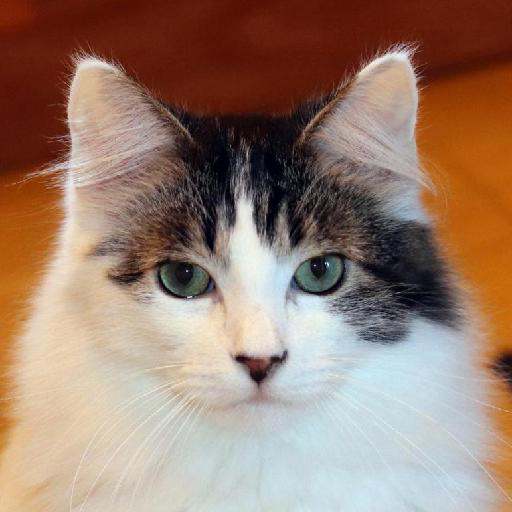

In [31]:

img = Image.open("./animal_data/val/cat/flickr_cat_000008.jpg").convert("RGB")
img

In [1]:
!pip install flask

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\user\anaconda3\envs\ocr_last\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
